In [1]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm_n

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

tqdm_n().pandas()

# INTRNLP MCO: Twitter Emoji Prediction
# Model
In this step, we build the classification model for predicting appropriate emoji given a tweet.

Note: Some of the "magic" cells contain Bash shell commands; these may not work on all platforms. However, all cells important in producing the final output have been written in Python for portability.

In [2]:
!ls data-clean

best_clf.joblib         tokens_emotions.csv     tweets.csv
grid_search.joblib      tokens_spacy.csv
grid_search_results.csv tokens_spacy_clean.csv


# X: Features

We declare X as the list of cleaned tweets -- tokens joined back together by spaces. Each tweet is joined into a single string so that we can use them as input for scikit-learn's **vectorizers**.

Reading clean SpaCy-generated tokens from `tokens_spacy_clean.csv`

In [3]:
tokens = pd.read_csv('data-clean/tokens_spacy_clean.csv', dtype={'token':str}, keep_default_na=False)
tokens.head()

,index,token
0,0,vacation
1,0,waste
2,0,vacation2017
3,0,photobomb
4,0,tired


Combining groups of tokens back into single strings separated by space character (for use in sklearn vectorizers)

In [4]:
tokens = tokens.groupby('index').progress_apply(lambda x : ' '.join(x['token']))
tokens.head()

index
0    vacation waste vacation2017 photobomb tired va...
1    oh wynwood be so funny wynwood art itwas3am fl...
2    be friend since 7th grade look at now all foll...
3    this be what look like when someone love uncon...
4    rt this white family be invite to a black barb...
dtype: object

In [5]:
X = tokens.values

# y: Labels

Our labels are the original emoji labels found in `Train.csv`, containing 20 possible classes.

Reading tweet-emoji pairs from `tweets.csv`

In [6]:
tweets = pd.read_csv('data-clean/tweets.csv')
tweets.head()

,text,emoji
0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,Been friends since 7th grade. Look at us now w...,2
3,This is what it looks like when someone loves ...,3
4,RT @user this white family was invited to a Bl...,3


In [7]:
y = tweets['emoji'][tokens.index].values

# Model selection

We experiment with permutations of the following:

Vectorizers
- Count
 - ngram_range (1,1)
 - max_df 1.0, 0.95
 - min_df 1, 0.05
 - max_features None, 500, 5000, 50000
- Term Frequency-Inverse Document Frequency
 - ngram_range (1,1)
 - max_df 1.0, 0.95
 - min_df 1, 0.05
 - max_features None, 500, 5000, 50000
 
Resampling
- None
- RandomUnderSampler (random_state=1 for consistency)

Models
- MultinomialNB (works better with word count data)
- ComplementNB (works better with imbalanced datasets)
- LinearSVC (SVM with linear kernel)

To find the best combination, we use grid search (via scikit-learn's GridSearchCV) with cross-validation fold count of 3 per pipeline. Because the dataset is imbalanced before resampling, we use the weighted average F1 score as the metric to maximize.

All in all, we test 192 possible combinations with 3 cross validation fits each.

<h1 style='background-color:red;color:white;padding:0.5rem'>&lt;SKIP&gt;</h1>

The following section contains code which takes a very long time to run. To save time, the output has been dumped to file. Skip ahead of this section to proceed to analysis.

In [58]:
# SVMs slow with several classes -- around 2^(n classes) minimum dimensions
# Try: ensemble of everything vs. boosted individual models

In [59]:
gscv = GridSearchCV(
    Pipeline([('vec', None), ('smp', None), ('clf', None)]),
    param_grid={
        'vec':[
            CountVectorizer(), 
            TfidfVectorizer()
        ],
        'vec__max_df':[
            1.0, 
            0.95
        ],
        'vec__min_df':[
            1, 
            0.05
        ],
        'vec__max_features':[
            None, 
            500,
            5000,
            50000
        ],
        'smp':[
            None, 
            RandomUnderSampler(random_state=1)
        ],
        'clf':[
            MultinomialNB(), 
            ComplementNB(), 
            LinearSVC(max_iter=1000, dual=False)
        ]
    },
    scoring='f1_weighted', cv=3, n_jobs=4, return_train_score=True, verbose=2
)

gscv.fit(X, y)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 576 out of 576 | elapsed: 23.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None, steps=[('vec', None), ('smp', None), ('clf', None)]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'vec': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        s...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=2)

Pickling GridSearchCV object and best estimator to file

In [105]:
dump(gscv, 'data-clean/grid_search.joblib')
dump(gscv.best_estimator_, 'data-clean/best_clf.joblib')

['data-clean/best_clf.joblib']

<h1 style='background-color:red;color:white;padding:0.5rem'>&lt;\SKIP&gt;</h1>

Loading GridSearchCV object and best estimator from file

In [15]:
gscv = load('data-clean/grid_search.joblib')
best_clf = gscv.best_estimator_

Representing the grid search results as a DataFrame

In [16]:
cv_results_df = pd.DataFrame(gscv.cv_results_)
cv_results_df.to_csv('data-clean/grid_search_results.csv', index=False)

In [17]:
cv_results_df.sort_values('mean_test_score', ascending=False)\
    [['mean_test_score']+[col for col in cv_results_df.columns if col.startswith('param_')]].head()

,mean_test_score,param_clf,param_smp,param_vec,param_vec__max_df,param_vec__max_features,param_vec__min_df
156,0.258125,"LinearSVC(C=1.0, class_weight=None, dual=False...",None,"TfidfVectorizer(analyzer='word', binary=False,...",0.95,5000,1
148,0.258125,"LinearSVC(C=1.0, class_weight=None, dual=False...",None,"TfidfVectorizer(analyzer='word', binary=False,...",1,5000,1
68,0.256957,"ComplementNB(alpha=1.0, class_prior=None, fit_...",None,"CountVectorizer(analyzer='word', binary=False,...",1,5000,1
76,0.256957,"ComplementNB(alpha=1.0, class_prior=None, fit_...",None,"CountVectorizer(analyzer='word', binary=False,...",0.95,5000,1
144,0.255288,"LinearSVC(C=1.0, class_weight=None, dual=False...",None,"TfidfVectorizer(analyzer='word', binary=False,...",1,None,1


The grid search shows that the **linear SVM classifier** using **TF-IDF vectorized features** is the best performing model of those tested. The best estimator yields a weighted $F_1$ score of $0.258$.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)
best_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

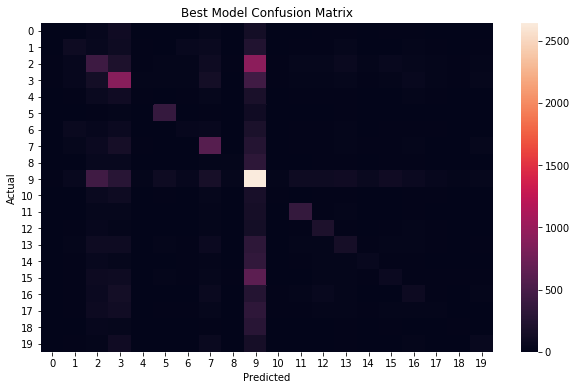

In [19]:
sns.heatmap(confusion_matrix(y_test, best_clf.predict(X_test)))
plt.title('Best Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

plt.gcf().set_size_inches(plt.gcf().get_size_inches()*1.5)

plt.savefig('figures/best_confusion_matrix.png', dpi=300)

We can see that much of the model's confusion comes from the emoji at index 9 -- the red heart &#10084;.

# Feature Importance

An examination of the final classifier's coefficients shows which features have the most weight on the decision for each class.

In [20]:
mapping = pd.read_csv('data-raw/Mapping.csv')[['emoticons', 'number']]
mapping.head()

,emoticons,number
0,😜,0
1,📸,1
2,😍,2
3,😂,3
4,😉,4


In [21]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm = cm / cm.sum(axis=1)
cm.diagonal()

array([0.01284797, 0.11953728, 0.20018841, 0.44130541, 0.02131439,
       0.64249578, 0.072     , 0.45683728, 0.0367893 , 0.58405125,
       0.03488372, 0.50136986, 0.34729494, 0.15384615, 0.07681366,
       0.07111882, 0.09882353, 0.02909091, 0.03488372, 0.10133843])

In [22]:
pd.Series(cm.diagonal(), index=mapping['emoticons']).sort_values(ascending=False)

emoticons
🎄     0.642496
❤     0.584051
🇺🇸    0.501370
🔥     0.456837
😂     0.441305
☀     0.347295
😍     0.200188
✨     0.153846
📸     0.119537
💯     0.101338
😎     0.098824
💙     0.076814
📷     0.072000
💕     0.071119
😘     0.036789
💜     0.034884
😁     0.034884
😊     0.029091
😉     0.021314
😜     0.012848
dtype: float64

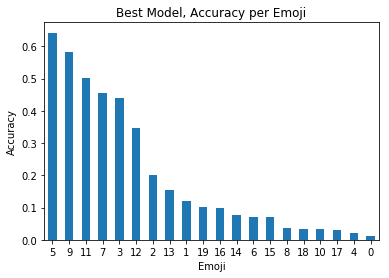

In [23]:
pd.Series(cm.diagonal(), index=range(20)).sort_values(ascending=False).plot(kind='bar')
plt.title('Best Model, Accuracy per Emoji')
plt.xlabel('Emoji')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.savefig('figures/class_accuracy.png', dpi=300)

The model has the highest accuracy predicting tweets associated with the emoji at index 5 -- the Christmas tree &#127876;. Upon examining the tokens associated with this class, we find that they are, in fact, mostly Christmas-related words such as "christmas", "tree", and, interestingly, "tis", as in "tis the season".

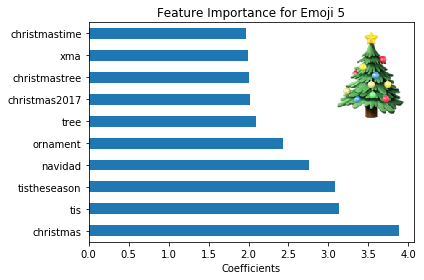

In [24]:
pd.Series(best_clf.steps[2][1].coef_[5], index=best_clf.steps[0][1].get_feature_names())\
    .sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Feature Importance for Emoji 5')
plt.xlabel('Coefficients')
plt.tight_layout()
ax = plt.axes([.72,.575,.3,.3])
ax.imshow(plt.imread('images/emoji_5.png'))
ax.axis('off')
plt.savefig('figures/feature_importance_emoji_5.png', dpi=300)

In [25]:
tweets[(tweets['text'].str.contains(r'\b\W*christmas\W*\b', case=False)) & (tweets['emoji']==5)].head(10)

,text,emoji
6,Merry Christmas you filthy little animals. Wea...,5
69,The first three ornaments on our Christmas tre...,5
126,Merry Christmas!! Enjoying a fun night chapero...,5
273,Drag Queen Christmas show with my queens. #chr...,5
375,"All I want for Christmas is you, #DiddyRiese! ...",5
385,Christmas ready . #christmas2017 #christmaseve...,5
464,Getting our Fraser Fir! @ Smoky Mountain Chris...,5
513,Carrowinds Winterfest Christmas Tree Lighting ...,5
798,Happy Holidays with 6 days to Christmas #happy...,5
921,Best Christmas Present ever. #coffee #keurig #...,5


The model succeeds in terms of prediction accuracy with this class because it has a distinct topic (Christmas) associated with it. It's easy to tie the Christmas tree to Christmas-themed tweets, and it's much less likely for it to appear in unrelated tweets that might throw the classifier off during training.

However, let's see the opposite of this scenario in emoji 9: the red heart &#10084;.

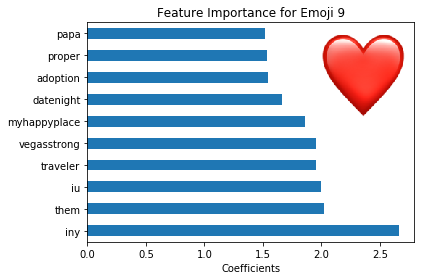

In [26]:
pd.Series(best_clf.steps[2][1].coef_[9], index=best_clf.steps[0][1].get_feature_names())\
    .sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Feature Importance for Emoji 9')
plt.xlabel('Coefficients')
plt.tight_layout()
ax = plt.axes([.7,.575,.3,.3])
ax.imshow(plt.imread('images/emoji_9.png'))
ax.axis('off')
plt.savefig('figures/feature_importance_emoji_9.png', dpi=300)

Unlike with the Christmas tree, there isn't a clear singular topic that the red heart is associated with.

In [27]:
tweets[(tweets['text'].str.contains(r'\b\W*iny\W*\b', case=False)) & (tweets['emoji']==9)].head(10)

,text,emoji
1056,#outandabout #iny @ Queensboro Plaza\n,9
2390,Celebrating this gorgeous spring day robiberow...,9
9598,#iny #nyc #beyounyc #lookpastpinkandblue @ Wes...,9
15219,INY @ Wall Street - Financial District NYC\n,9
21302,#gotham#boxingday #iny #muhammadali #miketyson...,9
24577,Looking beyond the Top of the Rock. #iny #nyc ...,9
25216,#ferrybeer #beerthirty #drinklocal @user #chee...,9
31556,#beamsoflight #911 #neverforget #moon #nyc #in...,9
35919,INY#newyorkgirl #newyorkstateofmind #newyorkli...,9
35940,Great view #manhattan #nyc #iloveny #iny #vaca...,9


In [28]:
tweets[(tweets['text'].str.contains(r'\b\W*vegasstrong\W*\b', case=False)) & (tweets['emoji']==9)].head()

,text,emoji
2892,#HuntingtonBeach showing some ️ for my home #L...,9
4686,One week ago today... paying my respects to my...,9
9611,Good Morning Vegas ️#rfjourney #vegasstrong #r...,9
11780,barepool #VegasStrong ️ @ Bare Pool Lounge\n,9
16145,The sun rises over Vegas ️ #VegasStrong #Vega...,9


Tokens `iny` and `vegasstrong`, two of the classifier's most important features for the red heart class, are very location-specific, applying to New York and Las Vegas respectively. Since these are US-specific locations, the model may be biased towards better performance with US-originating tweets, and fail to generalize well to the rest of the world.